# LLM - Bielik - Fine tuning - part II

## Introduction 

This is second part of small series related to LLM fine-tuning!

The goal of following article is to fine-tune one large language model - Bielik 11B from Speakleash (https://huggingface.co/speakleash). In first part <link to first part> we focused on data preparation. To achieve this, we generated data based on the polish legal document. Then, we measured the quality of the generated data using various metrics (distance and LLM based). As we proved the good quality of the generated question and answers based on the context, we formatted the data in order to follow a specific schema suitable for question-answering task for LLM.

Now let's dive deep into the fine-tuning itself!


# Prerequisites

In order to start working with model and finetuning let's install required libraries (also present in requirements.txt). Short intro to libraries:
- bitandbytes - setups config for quantization options
- transformers - core library for using Large Language Models and beyond
- accelerate - <em>Accelerate is a library that enables the same PyTorch code to be run across any distributed configuration by adding just four lines of code.</em> https://huggingface.co/docs/accelerate/en/index
- peft - our gem! <strong>P</strong>aremeter-<strong>E</strong>fficient <strong>F</strong>ine <strong>T</strong>uning library which allows to finetune small number of extra model paremeters instead of all which could be costly.
- wandb - weights and biases - useful for tracking the experiments (https://wandb.ai/site/)
- torch, torchvision, torchaudio - core PyTorch libraries for running neural networks.

In [1]:
# ! pip install bitsandbytes
# ! pip install transformers
# ! pip install accelerate
# ! pip install peft
# ! pip install wandb
# ! pip install datasets
# ! pip install ipywidgets==8.1.3
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [8]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, logging
import transformers
from datetime import datetime
from accelerate import Accelerator
from huggingface_hub import notebook_login
from peft import prepare_model_for_kbit_training, PeftModel, LoraConfig, get_peft_model
from src.helpers.data import load_data, plot_hist, generate_with_template, generate_and_tokenize_with_template
from src.data.val_dataset import get_validation_dataset
from src.inference.generation import generate_with_chat_template, pretty_output, get_score
from src.helpers.models import print_trainable_parameters
import seaborn as sns
from pypalettes import load_cmap
from IPython.display import Image
from src.external_requests.openai_req import OpenAIReq
from src.external_requests.prompting import PromptBuilder

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3...2...1...action!
Let's start with some helper functions:
- setting appropriate level of logging, because pytorch likes to spam all the output console.
- login to huggingface with credentials to be able to download some models - not every model is available without logging in.

In [4]:
logging.set_verbosity_warning()
# notebook_login()

To start with, let's focus on our model. Here, we want to load and setup appropriate model, Bielik 11B (v2.3-Instruct) in our case. We start with quantization config in order to make our model lighter. Then we get the model from HuggingFace Hub.

In [5]:
model_config = {
        'load_in_4bit':True,
        'bnb_4bit_use_double_quant':True,
        'bnb_4bit_quant_type':"nf4",
        'bnb_4bit_compute_dtype':torch.bfloat16
}

model_name = 'speakleash/Bielik-11B-v2.3-Instruct'

In [5]:
bnb_config = BitsAndBytesConfig(**model_config)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)

tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Having the model and aligned tokenizer loaded, let's head to data. In previous part of this tutorial we focused on generating data, questions and answers, to use for training the model specific task like handling user questions. Now, we need to split our data for training and evaluation set. Here, we did this process manually, by spliting the dataset and creating two separate files - training and eval. In this case around 80% is training dataset and around 20% is eval dataset.

In [13]:
train_data_path = 'ft_output_data/data_ft_20250130_221652_hq_train.jsonl'
eval_data_path = 'ft_output_data/data_ft_20250130_221652_hq_eval.jsonl'

In [14]:
train_dataset = load_data(path=train_data_path, type='train', format='json')
eval_dataset = load_data(path=eval_data_path, type='train', format='json')

After loading the data to a specific format suitable for fine-tuning, we need to preprocess the input data to be used for QA task. Our data now will have format appropriate to the model chat template. It will be also tokenized (transformed from words to numbers).

In [ ]:
# Expected data format:
#  [
#         {"role": "system", "content": "Jesteś asystentem prawniczym. Odpowiadaj krótko, precyzyjnie i wyłącznie w języku polskim."},
#         {"role": "user", "content": {question}},
#         {"role": "assistant", "content": {answer}}
#   ]

Questions and answers come from our prepared dataset.

In [16]:
tokenized_train_dataset = train_dataset.map(lambda x: generate_with_template(prompt=x, tokenizer=tokenizer))
tokenized_eval_dataset = eval_dataset.map(lambda x: generate_with_template(prompt=x, tokenizer=tokenizer))

Let us verify how long our sentences are. In the first part of article about data generation, we asked GPT model to deliver answers with a limit of 200 tokens. We set this limit to instruct the model to provide concise answer within this number. Combining questions and answers gives us numbers as below:

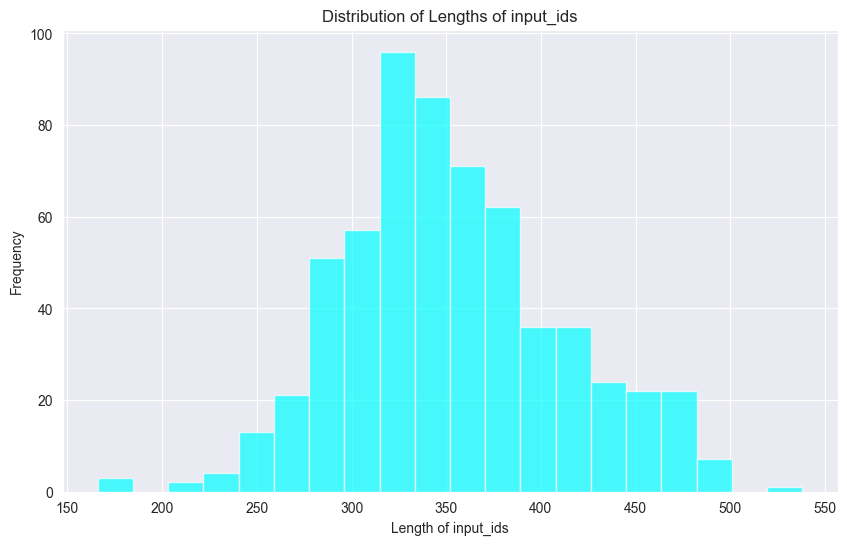

In [19]:
plot_hist(tokenized_train_dataset, tokenized_eval_dataset)

As shown, the majority of sentences are between 200 and 450 tokens in length. Now, for model usage we need to make all the sentences mand make them the same size and if the sentence is shorter we add padding.

In [20]:
max_length = 512

In [21]:
tokenized_train_dataset = train_dataset.map(lambda x: generate_and_tokenize_with_template(prompt=x, tokenizer=tokenizer, length=max_length))
tokenized_val_dataset = eval_dataset.map(lambda x: generate_and_tokenize_with_template(prompt=x, tokenizer=tokenizer, length=max_length))

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

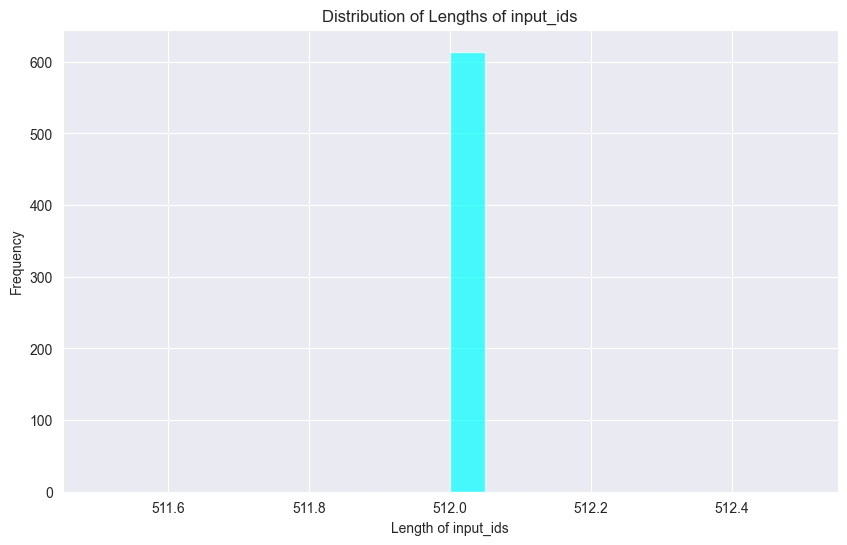

In [22]:
plot_hist(tokenized_train_dataset, tokenized_val_dataset)

## Model fine-tuning

At first, create our LORA config. Lora stands for Low-Rank Adaptation which breaks down the original model matrix into the two smaller ones, which drastically reduces the number of parameters which needs to be trained, maintaining quality and efficiency. The most important parameters we will take into consideration is R and alpha. R, for Rank, will determine how many trainable parameters we will train and alpha will determine how much focus we should put on new learned weights, Lora paper suggest that alpha should be 2x Rank. According to FartyPants (yeah, really - https://medium.com/@fartypantsham/what-rank-r-and-alpha-to-use-in-lora-in-llm-1b4f025fd133) we should be careful with this parameters as there is a chance that our model base capabilities will be devoured by new ones. 

Disclaimer! Those parameters and results are derived from multiple finetuning sessions with different parameters and approaches. Please do experiment on this field!

In [26]:
lora_params = {
    'r': 32,
    'alpha': 64,
    'layers': ["q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            "lm_head"],
    'dropout': 0.05
}

use_linear_layers = False
linear_layers = ['gate_proj', 'down_proj', 'up_proj', 'q_proj', 'v_proj', 'k_proj','o_proj']

config = LoraConfig(
    r=lora_params.get('r'),
    lora_alpha=lora_params.get('alpha'),
    target_modules=lora_params.get('layers') if not use_linear_layers else linear_layers,
    bias="none",
    lora_dropout=lora_params.get('dropout'),  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 132231168 || all params: 5848432640 || trainable%: 2.2609676154190947


In [23]:
model.gradient_checkpointing_enable() # this speeds up training on single GPU
model = prepare_model_for_kbit_training(model) # prepares model for training

In [27]:
accelerator = Accelerator()
model = accelerator.prepare_model(model)

## Training


Here, we are using some additional setup for tracking any experiments. We are using Weights and Biases (https://wandb.ai/) as an experiment tracker. 

In [ ]:
project = "legal-finetune"
base_model_name = "bielik-v2.3-instruct-11B"
params = f'r-{lora_params.get("r")}-alpha-{lora_params.get("alpha")}'
run_name = base_model_name + "-" + project + "-" + params + '-02022025_hq'
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=600,
        learning_rate=2.5e-5, 
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",        
        save_strategy="steps",       
        save_steps=25,                
        eval_strategy="steps", 
        eval_steps=25,               
        do_eval=True,                
        report_to="wandb",           
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

For sanity, logging of this process has been cleared to provide more readbality on the notebook. Nevertheless, a screenshot of expected output has been done.

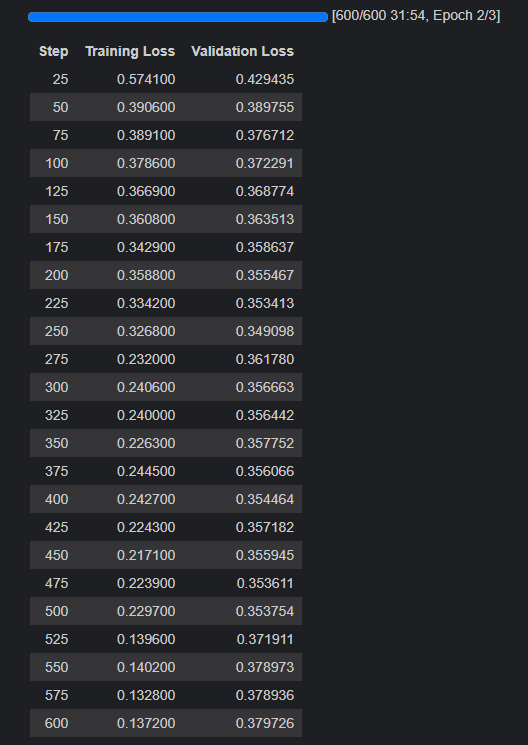

In [2]:
Image(filename='C:\\Users\\zjada\Desktop\\finetuning_process.png')

The process didn't take much time (around 20-30 minutes). Let's verify which checkpoint is the best one. It is not always the last one! From the above picture we can observe that validation loss started to increase after 500th step. Additionally, Weights amd Biases logged the whole process and after accessing our experiment online, we can see the chart:

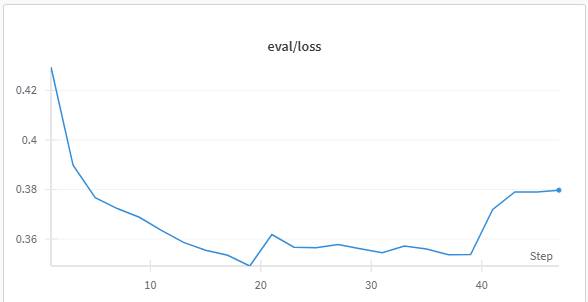

In [3]:
Image(filename='C:\\Users\\zjada\Desktop\\validation_loss.png')

In such case, we shouldn't rely on the last checkpoint, but let's focus on the ones with lower loss - we can definitely pick 500 instead of 600.
Now is also a time to load not only our base model but also our checkpoint:

In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,  
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

eval_tokenizer = AutoTokenizer.from_pretrained(model_name, skip_special_tokens=True)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
ft_model = PeftModel.from_pretrained(base_model, "bielik-v2.3-instruct-11B-legal-finetune-r-32-alpha-64-02022025_hq/checkpoint-500")

## Finetuning evaluation - is the new model truly better than base one?

For comparison results between non-finetuned model and finetuned one, the validation dataset is created with selected questions related to the topic of consumer rights. Questions and groundtruth answers come from https://prawakonsumenta.uokik.gov.pl/pytania-i-odpowiedzi/. We switched the source of questions in order to avoid data leakage (using train / eval dataset questions from earlier prepared data). This dataset is not verbose, it contains only 42 questions, but at this point should be enough to verify if the fine-tuning worked. Those questions and answers are prepared by Office of Competition and Consumer Protection in Poland. This gives our validation dataset additional credibility. Let's see our validation dataset:

In [5]:
validation_dataset = get_validation_dataset()
validation_dataset

,question,groundtruth
0,Kiedy jestem konsumentem?,Konsument to osoba fizyczna dokonująca z przed...
1,"Czy jestem konsumentem, gdy kupuję towar od os...","Nie jesteś konsumentem, gdy kupujesz towar od ..."
2,Co oznacza wyraźna zgoda na dodatkową płatność...,Wyraźną zgodę wyraża sam konsument. Nie można ...
3,Czy przedsiębiorca może dowolnie ustalać koszt...,"Nie, przedsiębiorca nie może ustalać tego w sp..."
4,Czy przy zakupie biletu do teatru obowiązują p...,"Tak, przepisy ustawy o prawach konsumenta stos..."
5,Kiedy jest niedozwolona odsprzedaż konsumentom...,Niedozwolona jest odsprzedaż konsumentom bilet...
6,Kiedy podwójna jakość produktów jest niezgodna...,Niezgodne z prawem jest wprowadzenie na polski...
7,Czy do umów o najem i rezerwację miejsc parkin...,"Tak, w przypadku tego typu umów stosuje się us..."
8,Czy sprzedawca może przenieść na konsumenta od...,Przedsiębiorca nie może przenieść na konsument...
9,Czy konsument może żądać od sprzedawcy potwier...,Jeżeli przedsiębiorca proponuje konsumentowi z...


In [12]:
output_col_name = 'answer'
current_model_eval = validation_dataset.copy()['question'].drop_duplicates()
current_model_eval = current_model_eval.to_frame()
current_model_eval['model_name'] = f'{model_name}_base_12022025_hq_chat_templ'

In [14]:
current_model_eval[output_col_name] = current_model_eval['question'].apply(lambda x: pretty_output(generate_with_chat_template(question=x, eval_model=base_model, eval_tokenizer=eval_tokenizer)))

C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\models\mistral\modeling_mistral.py:647: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [15]:
current_model_eval

,question,model_name,answer
0,Kiedy jestem konsumentem?,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nKonsumentem jesteś w sytuacji, gdy dokonu..."
1,"Czy jestem konsumentem, gdy kupuję towar od os...",speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nNie jesteś konsumentem, gdy kupujesz towa..."
2,Co oznacza wyraźna zgoda na dodatkową płatność...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nW kontekście umów, wyraźna zgoda na dodat..."
3,Czy przedsiębiorca może dowolnie ustalać koszt...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nTak, przedsiębiorca sam ustala koszt połą..."
4,Czy przy zakupie biletu do teatru obowiązują p...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nTak, przy zakupie biletu do teatru obowią..."
5,Kiedy jest niedozwolona odsprzedaż konsumentom...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,\n<|im_start|> user\nKiedy jest niedozwolona ...
6,Kiedy podwójna jakość produktów jest niezgodna...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,\n\nProdukty o podwójnej jakości stają się pr...
7,Czy do umów o najem i rezerwację miejsc parkin...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nOdpowiedź:\nTak, do umów o najem i rezerw..."
8,Czy sprzedawca może przenieść na konsumenta od...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nTak, sprzedawca może przenieść odpowiedzi..."
9,Czy konsument może żądać od sprzedawcy potwier...,speakleash/Bielik-11B-v2.3-Instruct_base_12022...,"\n\nTak, konsument ma prawo żądać od przedsię..."


Once having answers from the finetuned model, let's head to the assessment methods. For running the assessment, three metrics has been provided:
- clarity
- coherence
- accuracy

All those metrics are LLM based metrics with support of GPT4o. Similarly to the first notebook, we use instruct the model to provide a rating within a range from 1 to 5 and explanation. 

In [19]:
metric_name = 'clarity'

current_model_eval[metric_name] = current_model_eval[output_col_name].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x)))

In [17]:
metric_name = 'coherence'

current_model_eval[metric_name] = current_model_eval[output_col_name].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_coherence_pl(x)))

In [18]:
metric_name = 'accuracy'

current_model_eval[metric_name] = current_model_eval.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy_pl(x['question'], x[output_col_name])), axis=1)

In [21]:
current_model_eval['coherence_score'] = current_model_eval[metric_name].apply(get_score)
current_model_eval['accuracy_score'] = current_model_eval[metric_name].apply(get_score)
current_model_eval['clarity_score'] = current_model_eval[metric_name].apply(get_score)

As a next step, we should run the same evaluation for base model (no finetuning) and for groundtruth. This step has already been done in the background, so let's share the results:

In [15]:
val_dataset = pd.read_csv('data/evaluation_results.csv', sep='|')
val_dataset

,question,answer,coherence,coherence_score,accuracy,accuracy_score,clarity,clarity_score,model_name
0,Kiedy jestem konsumentem?,Konsument to osoba fizyczna dokonująca z przed...,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,"{\n ""score"": 5,\n ""explanation"": ""Odpowiedź ...",5,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,groundtruth
1,"Czy jestem konsumentem, gdy kupuję towar od os...","Nie jesteś konsumentem, gdy kupujesz towar od ...","{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,"{\n ""score"": 5,\n ""explanation"": ""Odpowiedź ...",5,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,groundtruth
2,Co oznacza wyraźna zgoda na dodatkową płatność...,Wyraźną zgodę wyraża sam konsument. Nie można ...,"{\n ""score"": 5,\n ""explanation"": ""Tekst jest...",5,"{\n ""score"": 5,\n ""explanation"": ""Odpowiedź ...",5,"{\n ""score"": 5,\n ""explanation"": ""Tekst jest...",5,groundtruth
3,Czy przedsiębiorca może dowolnie ustalać koszt...,"Nie, przedsiębiorca nie może ustalać tego w sp...","{\n ""score"": 5,\n ""explanation"": ""Tekst jest...",5,"{\n ""score"": 5,\n ""explanation"": ""Odpowiedź ...",5,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,groundtruth
4,Czy przy zakupie biletu do teatru obowiązują p...,"Tak, przepisy ustawy o prawach konsumenta stos...","{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,"{\n ""score"": 5,\n ""explanation"": ""Odpowiedź ...",5,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,groundtruth
...,...,...,...,...,...,...,...,...,...
163,Czy w przypadku zakupów na odległość można ods...,"\n\nTak, w przypadku umów zawieranych na odle...","{\n ""score"": 3,\n ""explanation"": ""Tekst jest...",4,"{\n ""score"": 4,\n ""explanation"": ""Odpowiedź ...",4,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,speakleash/Bielik-11B-v2.3-Instruct_base_12022...
164,Konsument odstępuje od umowy zawartej na odleg...,\n\nUstawa o prawach konsumenta nie zawiera p...,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,"{""score"": 4, ""explanation"": ""Odpowiedź jest do...",4,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,speakleash/Bielik-11B-v2.3-Instruct_base_12022...
165,Czy mam prawo odstąpić od umowy dotyczącej usł...,\n\nW zależności od szczegółowych okolicznośc...,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,"{""score"": 4, ""explanation"": ""Odpowiedź jest tr...",4,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,speakleash/Bielik-11B-v2.3-Instruct_base_12022...
166,W jakim terminie konsument może odstąpić od um...,\n\nZgodnie z art. 38 pkt 13 ustawy o prawach...,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,"{\n ""score"": 2,\n ""explanation"": ""Odpowiedź ...",4,"{\n ""score"": 4,\n ""explanation"": ""Tekst jest...",4,speakleash/Bielik-11B-v2.3-Instruct_base_12022...


In [20]:
val_dataset['model_name'].value_counts()

model_name
groundtruth                                                        42
speakleash/Bielik-7B-base                                          42
speakleash/Bielik-11B-v2.3-Instruct_base                           42
speakleash/Bielik-11B-v2.3-Instruct_base_12022025_hq_chat_templ    42
Name: count, dtype: int64

In [21]:
melted = pd.melt(val_dataset, id_vars=['model_name'], value_vars=['coherence_score','accuracy_score', 'clarity_score'])

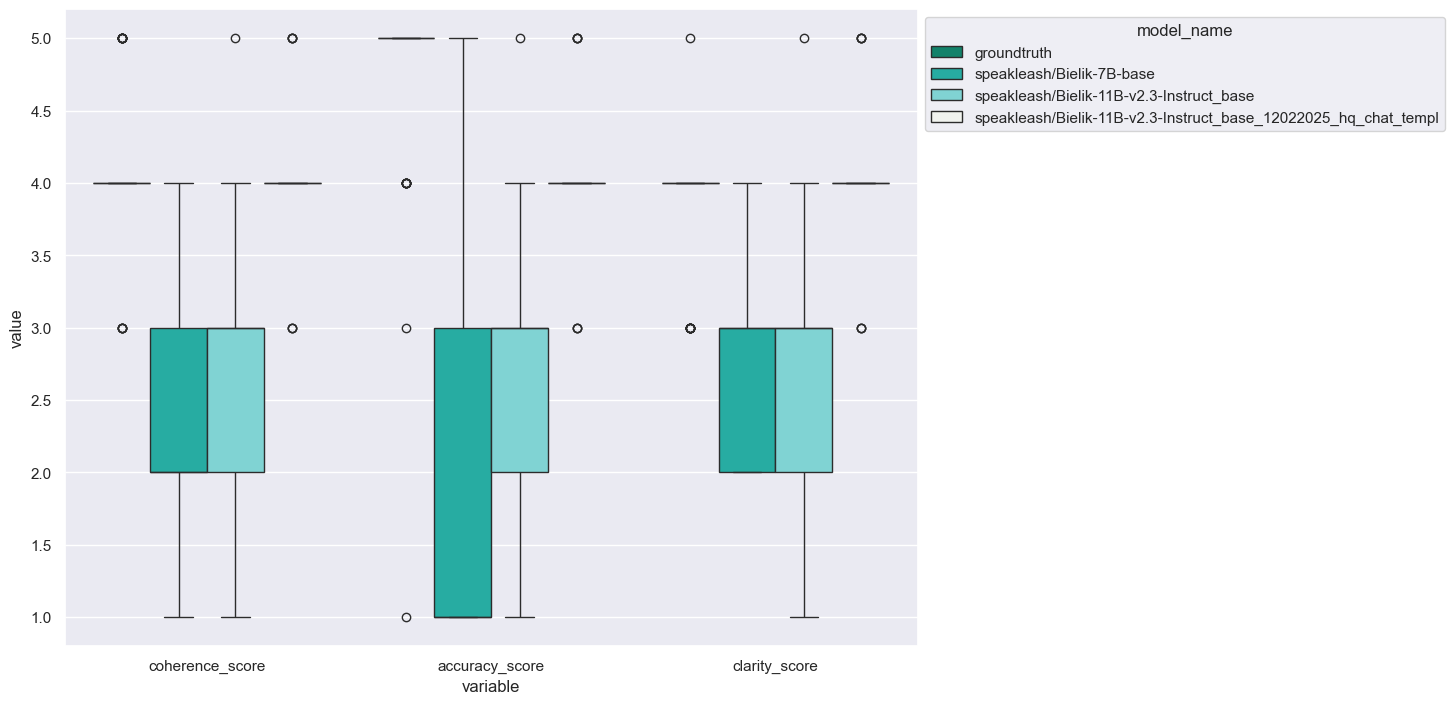

In [22]:
c_palette = load_cmap('Anemone',keep_first_n=4).hex
sns.set_theme(rc={'figure.figsize':(11,8.27)})

box_plot = sns.boxplot(melted, y='value', x='variable', hue='model_name', palette=c_palette)
sns.move_legend(box_plot, "upper left", bbox_to_anchor=(1, 1))

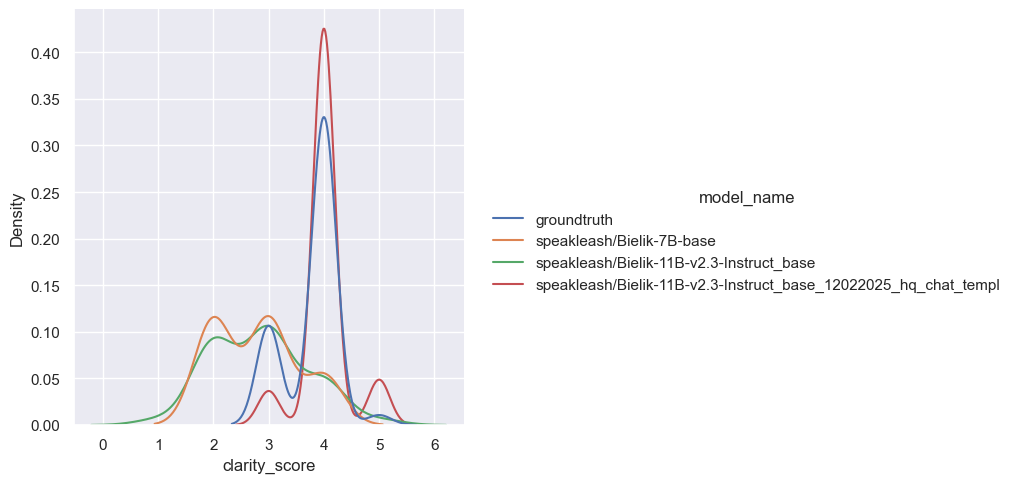

In [23]:
sns.displot(val_dataset, x="clarity_score", hue="model_name", kind="kde")

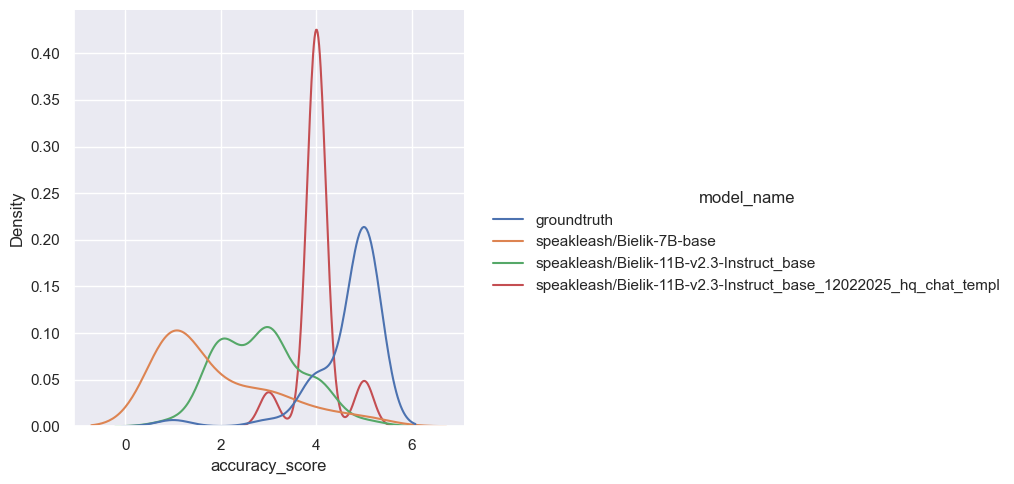

In [24]:
sns.displot(val_dataset, x="accuracy_score", hue="model_name", kind="kde")

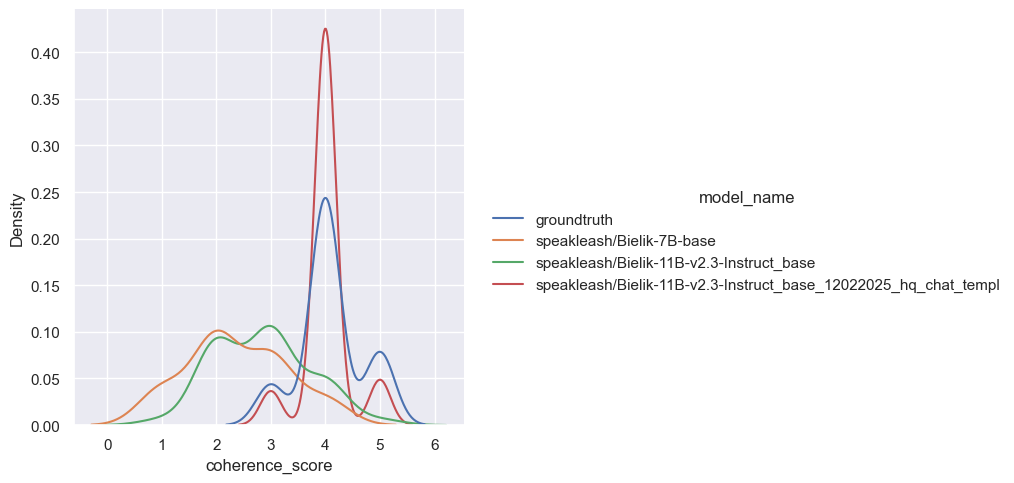

In [25]:
sns.displot(val_dataset, x="coherence_score", hue="model_name", kind="kde")